In [54]:
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.signal
import sys
sys.path.append('../src')
import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
trials = [5, 7, 9, 7, 7, 8] # maximize clip-wise val acc
icassp_thresholds = 1.0 - np.logspace(-9, 0, 181)[::-1]
n_thresholds = len(icassp_thresholds)
tolerance = 0.5 # in seconds


# Define directory for model.
aug_str = "all"
model_name = "icassp-convnet"
if not aug_str == "none":
    model_name = "_".join([model_name, "aug-" + aug_str])
model_dir = os.path.join(models_dir, model_name)


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

# Loop over recording units.
for test_unit_id in range(n_units):
    test_unit_str = units[test_unit_id]
    unit_dir = os.path.join(model_dir, test_unit_str)
    trial_id = trials[test_unit_id]
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)
    prediction_name = "_".join([
        dataset_name,
        model_name,
        "test-" + test_unit_str,
        trial_str,
        "predict-" + test_unit_str,
        "full-predictions.csv"])
    prediction_path = os.path.join(trial_dir, prediction_name)
    prediction_df = pd.read_csv(prediction_path)

    annotation_path = os.path.join(annotations_dir,
        test_unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    n_relevant = len(relevant)

    odf = np.array(prediction_df["Predicted probability"])
    timestamps = np.array(prediction_df["Timestamp"])


    for th_id, threshold in enumerate(icassp_thresholds):
        peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
        peak_times = timestamps[peak_locations]
        peak_values = odf[peak_locations]
        
        selected = peak_times[peak_values > threshold]

        selected_relevant = mir_eval.util.match_events(
            relevant, selected, tolerance)

        true_positives = len(selected_relevant)
        n_selected = len(selected)
        false_positives = n_selected - true_positives
        false_negatives = n_relevant - true_positives

        tp_matrix[th_id, test_unit_id] = true_positives
        fp_matrix[th_id, test_unit_id] = false_positives
        fn_matrix[th_id, test_unit_id] = false_negatives
        
        
icassp_tp = np.sum(tp_matrix, axis=1)
icassp_fp = np.sum(fp_matrix, axis=1)
icassp_fn = np.sum(fn_matrix, axis=1)

icassp_precisions = 100 * icassp_tp / (icassp_tp+icassp_fp)
icassp_recalls = 100 * icassp_tp / (icassp_tp+icassp_fn)
icassp_f1_scores = 2*icassp_precisions*icassp_recalls /\
    (icassp_precisions+icassp_recalls)
    

icassp_precisions = [100.0] + list(icassp_precisions)[::-1] + [0.0]
icassp_recalls = [0.0] + list(icassp_recalls)[::-1] + [100.0]
icassp_f1_scores = [0.0] + list(icassp_f1_scores)[::-1] + [0.0]

In [48]:
th_id = len(icassp_thresholds) - 1
threshold = icassp_thresholds[th_id]

peak_locations = localmodule.pick_peaks(odf)
peak_times = timestamps[peak_locations]
peak_values = odf[peak_locations]
selected = peak_times[peak_values > threshold]

selected_relevant = mir_eval.util.match_events(
    relevant, selected, tolerance)

true_positives = len(selected_relevant)
n_selected = len(selected)
false_positives = n_selected - true_positives
false_negatives = n_relevant - true_positives

icassp_precisions = 100 * true_positives / (true_positives+false_positives)
icassp_recalls = 100 * true_positives / (true_positives+false_negatives)

not_relevant = [x for x in selected if x not in relevant]

deltas = []
for x in not_relevant:
    closest_relevant = relevant[np.argmin(np.abs(relevant - x))]
    deltas.append(closest_relevant - x)

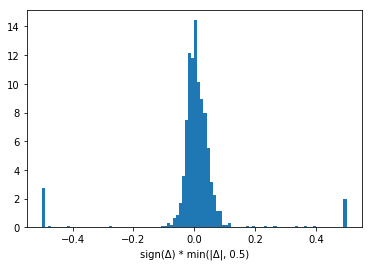

In [83]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(np.sign(deltas) * np.minimum(np.abs(deltas), 0.5), bins=100, normed=True)
plt.xlabel('sign(Δ) * min(|Δ|, 0.5)')

In [90]:
np.sort(np.diff(peak_times))

array([ 0.15 ,  0.15 ,  0.15 , ...,  2.189,  2.264,  2.641])

In [4]:
models_dir = localmodule.get_models_dir()
model_name = "SKM"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)

unit_relevant = []
unit_selected, unit_tp = [], []
for unit_str in units:
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([model_name, tol_str, unit_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    precisions = np.array(df["precision (%)"])
    precisions = np.insert(precisions, 0, 0.0)
    precisions = np.append(precisions, 100)
    precisions = precisions[::-1] / 100
    recalls = np.array(df["recall (%)"])
    recalls = np.insert(recalls, 0, 100.0)
    recalls = np.append(recalls, 0.0)
    recalls = recalls[::-1] / 100
    unit_relevant.append(np.array(df["relevant"])[0])
    unit_selected.append(np.array(df["selected"]))
    unit_tp.append(np.array(df["true positives"]))
    

relevant = np.sum(np.array(unit_relevant))
selected = np.sum(np.stack(unit_selected), axis=0)
tp = np.sum(np.stack(unit_tp), axis=0)
precisions = tp / selected
recalls = tp / relevant
precisions = np.insert(precisions, 0, 0.0)
precisions = np.append(precisions, 1.0)
precisions = 100 * precisions[::-1]
recalls = np.insert(recalls, 0, 1.0)
recalls = np.append(recalls, 0.0)
recalls = 100 * recalls[::-1]

skm_precisions = precisions
skm_recalls = recalls
skm_f1_scores = 2*skm_precisions*skm_recalls / (skm_precisions+skm_recalls)

In [5]:
models_dir = localmodule.get_models_dir()
model_name = "oldbird"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)
prefix = "_".join([dataset_name, "oldbird_merged_clip-suppressor"])
n_thresholds = 100

unit_relevant = []
unit_selected, unit_tp = [], []

tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

for unit_id, unit_str in enumerate(units):
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([prefix, unit_str, tol_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    true_positives = np.array(df["True positives"])
    tp_matrix[:, unit_id] = true_positives
    false_positives = np.array(df["False positives"])
    fp_matrix[:, unit_id] = false_positives
    false_negatives = np.array(df["False negatives"])
    fn_matrix[:, unit_id] = false_negatives
    
    
oldbird_tp = np.sum(tp_matrix, axis=1)
oldbird_fp = np.sum(fp_matrix, axis=1)
oldbird_fn = np.sum(fn_matrix, axis=1)

eps = np.finfo(float).eps
oldbird_precisions = 100 * oldbird_tp / (eps+oldbird_tp+oldbird_fp)
oldbird_recalls = 100 * oldbird_tp / (eps+oldbird_tp+oldbird_fn)

sorting_indices = np.argsort(oldbird_recalls)
oldbird_precisions = oldbird_precisions[sorting_indices]
oldbird_recalls = oldbird_recalls[sorting_indices]

oldbird_f1_scores = 2*oldbird_precisions*oldbird_recalls / (eps+oldbird_precisions+oldbird_recalls)

oldbird_precisions = np.insert(oldbird_precisions, 0, 100.0)
oldbird_precisions = np.append(oldbird_precisions, 0.0)
oldbird_recalls = np.insert(oldbird_recalls, 0, 0.0)
oldbird_recalls = np.append(oldbird_recalls, 100.0)

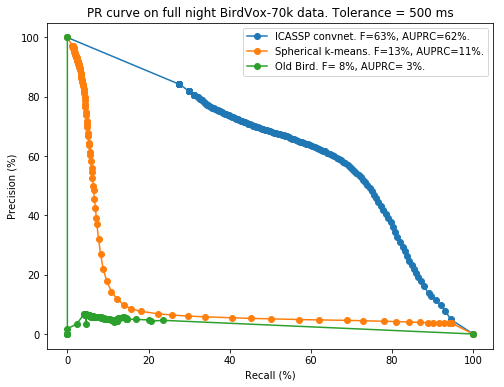

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 6))

icassp_f1_score = np.max(icassp_f1_scores)
icassp_auprc = np.trapz(icassp_precisions, icassp_recalls) / 100
icassp_label = "ICASSP convnet. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    icassp_f1_score, icassp_auprc)
plt.plot(icassp_recalls, icassp_precisions, "-o", label=icassp_label)

skm_f1_score = np.max(skm_f1_scores)
skm_auprc = np.trapz(skm_precisions, skm_recalls) / 100
skm_label = "Spherical k-means. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    skm_f1_score, skm_auprc)
plt.plot(skm_recalls, skm_precisions, "-o", label=skm_label)

oldbird_f1_score = np.max(oldbird_f1_scores)
oldbird_auprc = np.trapz(oldbird_precisions, oldbird_recalls) / 100
oldbird_label = "Old Bird. F={:2.0f}%, AUPRC={:2.0f}%.".format(
    oldbird_f1_score, oldbird_auprc)
plt.plot(oldbird_recalls, oldbird_precisions, "-o", label=oldbird_label)

plt.title("PR curve on full night BirdVox-70k data. Tolerance = {} ms".format(tolerance_ms))
plt.xlabel("Recall (%)")
plt.ylabel("Precision (%)")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (181,) and (183,)

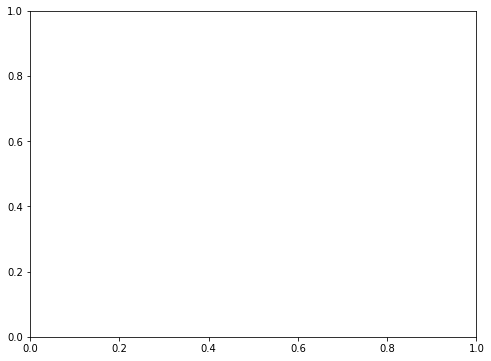

In [143]:
plt.figure(figsize=(8, 6))
plt.plot(
    np.linspace(0.0, 1.0, len(icassp_thresholds)), icassp_f1_scores, '-o',
    label="ICASSP convnet with data augmentation")
plt.plot(
    np.linspace(0.0, 1.0, 102), skm_f1_scores, '-o',
    label="Out-of-sample spherical k-means")
plt.plot(
    np.linspace(0.0, 1.0, 100), oldbird_f1_scores, '-o',
    label="Old Bird")
plt.legend()